In [1]:
# Basics ---------------------------------------------------------------
import logging
import pickle
# Data -----------------------------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
# Machine learning -----------------------------------------------------
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder
)
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    cohen_kappa_score,
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

In [2]:
logger = logging.getLogger()
logger.setLevel(logging.ERROR)

In [3]:
df_raw = pd.read_csv('../data/car.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   vhigh    1727 non-null   object
 1   vhigh.1  1727 non-null   object
 2   2        1727 non-null   object
 3   2.1      1727 non-null   object
 4   small    1727 non-null   object
 5   low      1727 non-null   object
 6   unacc    1727 non-null   object
dtypes: object(7)
memory usage: 94.6+ KB


In [4]:
df_raw.sample(10,random_state=2025)

,vhigh,vhigh.1,2,2.1,small,low,unacc
360,vhigh,low,3,4,small,med,unacc
1016,med,high,3,more,small,low,unacc
447,high,vhigh,2,4,big,med,unacc
272,vhigh,med,4,2,med,low,unacc
554,high,high,2,4,big,low,unacc
1626,low,low,2,2,big,med,unacc
1433,low,high,3,2,med,low,unacc
1701,low,low,5more,2,small,med,unacc
1502,low,high,5more,more,small,low,unacc
652,high,med,2,2,med,high,unacc


##### **Data dictionary**
|Name|Description|Type|Units|
|----|-----------|----|-----|
|buying|buying price|Category|vhigh, high, med, low|
|maint|price of the maintenance|Category|vhigh, high, med, low|
|doors|number of doors|Category|2, 3, 4, 5more|
|persons|capacity in terms of persons to carry|Category|2, 4, more|
|lug_boot|the size of luggage boot|Category|small, med, big|
|safety|estimated safety of the car|Category|low, med, high|
|class|evaulation level|Category|unacc, acc, good, vgood|

In [5]:
df_baking = df_raw.copy()
df_baking.columns = ['buying', 'maint', 'doors', 'persons', 'lug_boot', 'safety', 'class']
df_baking = df_baking.astype(
    {'buying': 'category',
     'maint': 'category',
     'doors': 'category',
     'persons': 'category',
     'lug_boot': 'category',
     'safety': 'category',
     'class': 'category'}
)
df = df_baking.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1727 entries, 0 to 1726
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   buying    1727 non-null   category
 1   maint     1727 non-null   category
 2   doors     1727 non-null   category
 3   persons   1727 non-null   category
 4   lug_boot  1727 non-null   category
 5   safety    1727 non-null   category
 6   class     1727 non-null   category
dtypes: category(7)
memory usage: 13.1 KB


In [6]:
df_train, df_test = train_test_split(
    df, test_size=0.2,
    stratify=df['class'],
    random_state=2024
)
df_train, df_val = train_test_split(
    df_train, test_size=0.2,
    stratify=df_train['class'],
    random_state=2024
)
df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((1104, 7), (277, 7), (346, 7))

In [7]:
df_train.describe(include='category').T

,count,unique,top,freq
buying,1104,4,low,284
maint,1104,4,high,283
doors,1104,4,5more,287
persons,1104,3,4,375
lug_boot,1104,3,med,376
safety,1104,3,high,371
class,1104,4,unacc,773


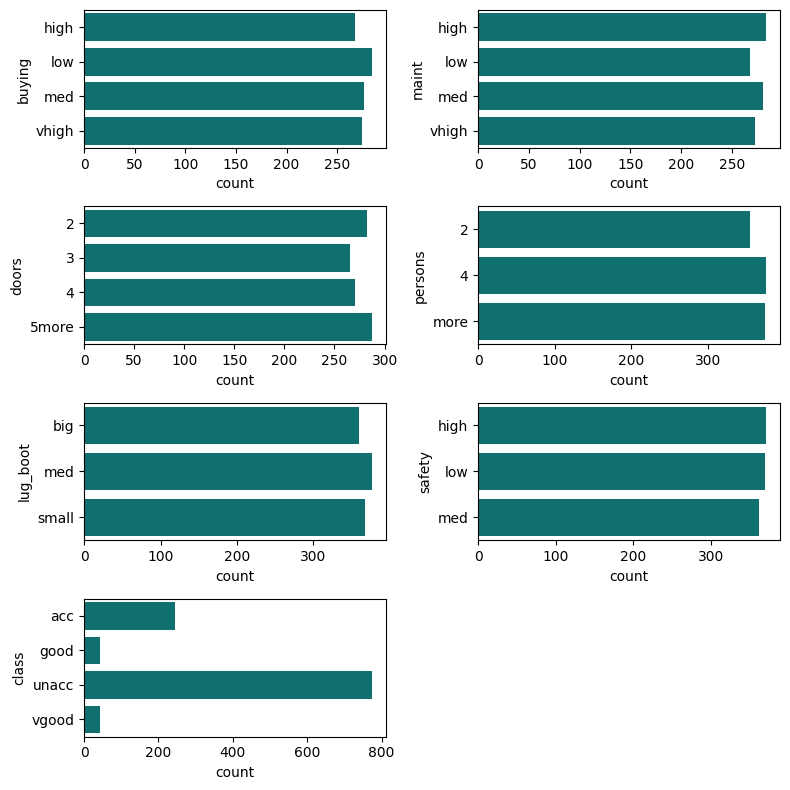

In [8]:
# Univariate analysis
fig, ax = plt.subplots(4,2, figsize=(8,8))
axes = ax.flatten()
for i, ax in enumerate(axes):
    if i<df_train.shape[1]:
        sns.countplot(df_train.iloc[:,i], color='Teal', ax=ax)
    else:
        axes[-1].remove()
plt.tight_layout()
plt.show()

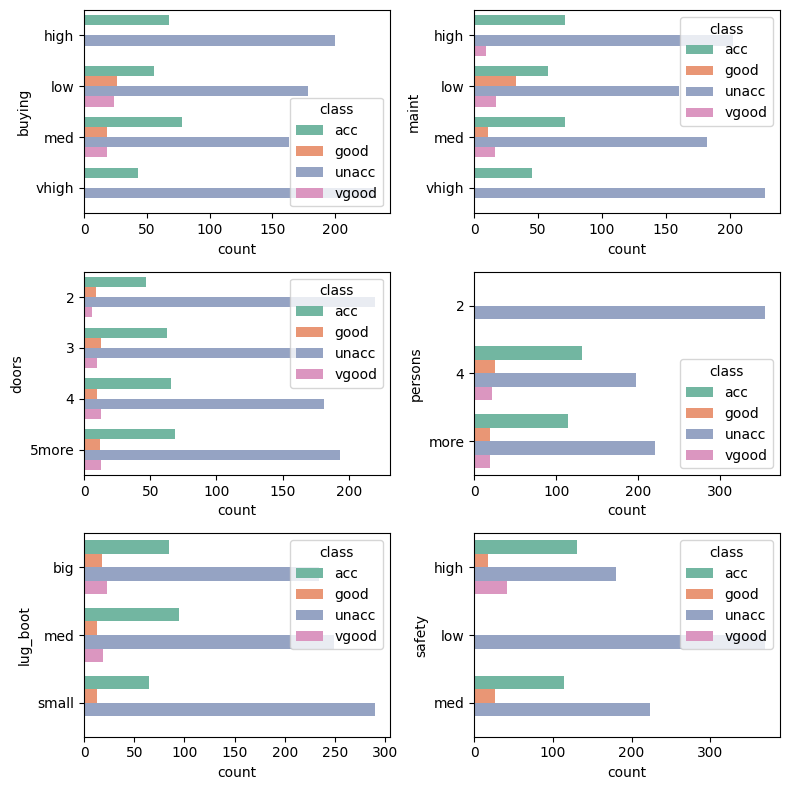

In [9]:
# Bivariate analysis
fig, ax = plt.subplots(3,2, figsize=(8,8))
axes = ax.flatten()
cols = df_train.columns.to_list()
for i, ax in enumerate(axes):
    if i<df_train.shape[1]:
        sns.countplot(df_train, y=cols[i], hue=cols[-1], ax=ax, palette='Set2')
plt.tight_layout()
plt.show()

In [10]:


X_train = df_train.drop(columns=['class'])
y_train = df_train['class']
X_val = df_val.drop(columns=['class'])
y_val = df_val['class']
X_test = df_test.drop(columns=['class'])
y_test = df_test['class']

In [11]:
label_encoder = LabelEncoder()
y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

In [12]:
clf_rforest_p = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('rforest', RandomForestClassifier(class_weight='balanced'))
])
clf_rforest_p

Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore')),
                ('rforest', RandomForestClassifier(class_weight='balanced'))])

In [13]:
clf_rforest_cv = GridSearchCV(
    clf_rforest_p,
    param_grid={
        'rforest__n_estimators': [10, 20, 30, 50, 100, 200, 300],
        'rforest__max_depth': [None, 2,3,4,5,6,7],
    },
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1
)

In [14]:
clf_rforest_cv.fit(X_train, y_train_enc)
clf_rforest_cv.best_params_

{'rforest__max_depth': None, 'rforest__n_estimators': 200}